#DATA AUGMENTATION


In [ ]:
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Image width: 640, Image height: 480


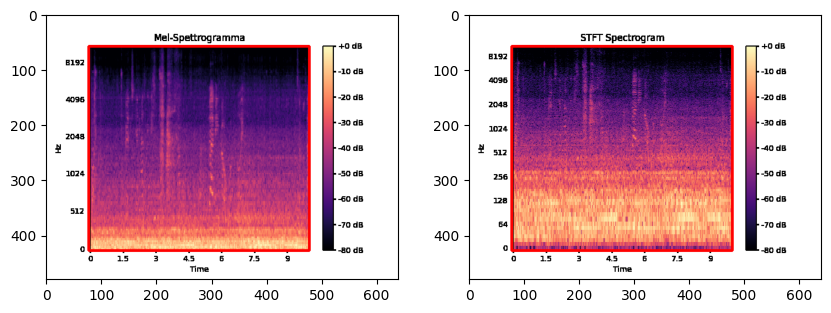

In [ ]:
#Plot a stft and a mel spectrogram, bording the spectrogram image with red
import matplotlib.pyplot as plt
audio_path1 = '/content/drive/MyDrive/DeepLearningProject/data/output/mel-grams/class_tram/a076_70_80.png'
audio_path2 = '/content/drive/MyDrive/DeepLearningProject/data/output/stft-grams/class_tram/a076_70_80.png'

from PIL import Image

def get_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        return width, height
width, height = get_image_size(audio_path1)
print(f"Image width: {width}, Image height: {height}")


import cv2

# coordinates and size of the red square to crop later
x = 77
y = 58
width = 400
height = 370

color = (0, 0, 255)
thickness = 4


image = cv2.imread(audio_path1)
cv2.rectangle(image, (x, y), (x + width, y + height), color, thickness)
image_rgb_1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.imread(audio_path2)
cv2.rectangle(image, (x, y), (x + width, y + height), color, thickness)
image_rgb_2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb_1)

plt.subplot(1, 2, 2)
plt.imshow(image_rgb_2)

plt.show()

##Step 1: read, preprocess the data and split in train, validation and test set

Since the mel spectrograms performed well, we going to chose that for the augmentation phase

In [ ]:
import tensorflow as tf

PREV_IMAGE_HEIGHT = 480
PREV_IMAGE_WIDTH = 640
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 16
N_CHANNELS = 3
N_CLASSES = 15
EPOCHS = 50
AUTO = tf.data.AUTOTUNE

In [ ]:
import tensorflow as tf
import os

#Since we saved the spectrograms with the decibel scale and legend, we just crop the spectrogram
def preprocessing(image):

    x = 77
    y = 58
    width = 400
    height = 370

    cropped_image_array = tf.image.crop_to_bounding_box(image, y, x, height, width)
    resized_image = tf.image.resize(cropped_image_array, (256, 256))

    return resized_image

spectrogram_directory = '/content/drive/MyDrive/DeepLearningProject/data/output/mel-grams'

spec_data_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory=spectrogram_directory,
    seed=0,
    shuffle=True,
    image_size=(PREV_IMAGE_HEIGHT, PREV_IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    subset='training')

spec_data_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory=spectrogram_directory,
    seed=0,
    shuffle=True,
    image_size=(PREV_IMAGE_HEIGHT, PREV_IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    subset='validation',)


#crop, normalization of images and one_hot encoding of classes
spec_data_train = spec_data_train.map(lambda x, y: (preprocessing(x)/255, tf.one_hot(y, N_CLASSES)))
spec_data_test = spec_data_test.map(lambda x, y: (preprocessing(x)/255, tf.one_hot(y, N_CLASSES)))
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

Found 4680 files belonging to 15 classes.
Using 3978 files for training.
Found 4680 files belonging to 15 classes.
Using 702 files for validation.


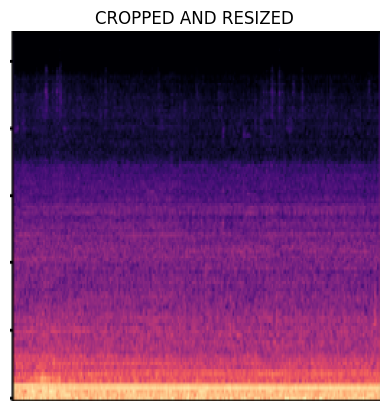

In [ ]:
train_iterator = spec_data_train.as_numpy_iterator()


first_batch_images, first_batch_labels = next(train_iterator)

# Access the first image and its corresponding label in the batch
first_image = first_batch_images[0]
first_label = first_batch_labels[0]


plt.imshow(first_image)
plt.axis('off')
plt.title("CROPPED AND RESIZED")
plt.show()

In [ ]:
val_samples = spec_data_train.cardinality().numpy()*0.2
val_ds = spec_data_train.take(val_samples)
train_dss = spec_data_train.skip(val_samples)
test_ds = spec_data_test
# test_ds = tf.data.Dataset.from_tensor_slices((images_test, labels_test)).batch(BATCH_SIZE)
print("Validation set shape and size")
print(val_ds.element_spec)
print(val_ds.cardinality())

print("Test set shape and size")
print(test_ds.element_spec)
print(test_ds.cardinality())

print("Training set shape and size")
print(train_dss.element_spec)
print(train_dss.cardinality())

Validation set shape and size
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))
tf.Tensor(49, shape=(), dtype=int64)
Test set shape and size
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))
tf.Tensor(44, shape=(), dtype=int64)
Training set shape and size
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))
tf.Tensor(200, shape=(), dtype=int64)


In [ ]:
import numpy as np

#transform training set into a numpy iterable list and split the images and the labels

def get_images_labels(ds):
  numpy_data = list(ds.as_numpy_iterator())
  all_images = np.concatenate([item[0] for item in numpy_data], axis=0)
  all_labels = np.concatenate([item[1] for item in numpy_data], axis=0)
  return all_images, all_labels


#Step 2: define mix_up function and apply it to 2 shuffled dataset obtained from the training set

In [ ]:
#Code taken and modified from https://keras.io/examples/vision/mixup/
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [ ]:

#extract all the images and labels in order to shuffle everything and not just the batches
all_images, all_labels = get_images_labels(train_dss)

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((all_images, all_labels))
    .shuffle(BATCH_SIZE * train_dss.cardinality())
    .batch(BATCH_SIZE)
)

train_ds_two = (
    tf.data.Dataset.from_tensor_slices((all_images, all_labels))
    .shuffle(BATCH_SIZE * traun_dss.cardinality())
    .batch(BATCH_SIZE)
)

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))


In [ ]:
# Create the new dataset using mix_up function
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

In [ ]:
print(train_ds_mu.cardinality())
print(train_ds_mu.element_spec)

tf.Tensor(200, shape=(), dtype=int64)
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))


In [ ]:
#save the augmented images
import tensorflow as tf
save_path = '/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_mixup_crop_mel_16.tfrecord'

tf.data.Dataset.save(train_ds_mu, save_path)

Plot first 9 mixed up images and labels

[0.0, 0.37129393219947815, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6287060976028442, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.03998817503452301, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9600118398666382, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9995344877243042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004654930380638689, 0.0]
[0.0, 0.0, 0.0, 0.17841988801956177, 0.0, 0.0, 0.0, 0.8215801119804382, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.9572190046310425, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04278099536895752, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.9999344944953918, 6.55055046081543e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9360079169273376, 0.0, 0.0, 0.0, 0.0, 0.06399208307266235]
[0.0, 0.0, 0.0, 0.0006569027900695801, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9993430972099304, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.7211194038391113, 0.0, 0.0, 0.27888059616088867, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


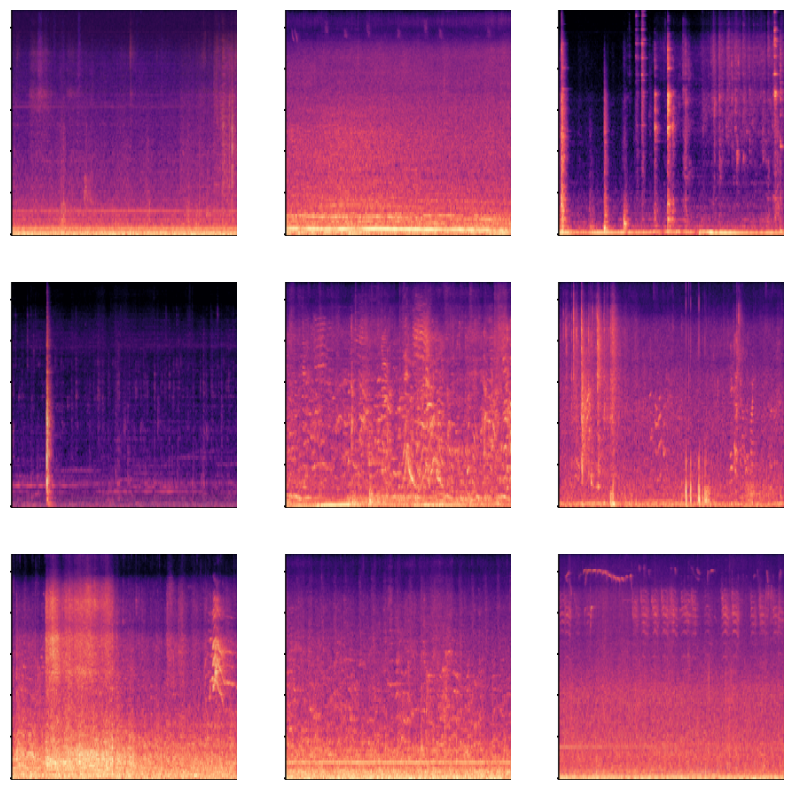

In [ ]:


# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu.take(10)))

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):

    #image = image / 255.0
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")



#Step 4: Define Spec augment function, create and save the trained augmented file

In [ ]:
import random

def spec_augment(spec):
    spec = np.array(spec)

    freq_masking_max_percentage = 0.15
    time_masking_max_percentage = 0.3

    augmented_spec = spec.copy()
    all_frames_num, all_freqs_num, _ = augmented_spec.shape

    # Frequency masking
    freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
    num_freqs_to_mask = int(freq_percentage * all_freqs_num)
    f0 = random.randint(0, all_freqs_num - num_freqs_to_mask)

    augmented_spec[f0:(f0 + num_freqs_to_mask), :] = 1

    # Time masking
    time_percentage = random.uniform(0.0, time_masking_max_percentage)
    num_frames_to_mask = int(time_percentage * all_frames_num)
    t0 = random.randint(0, all_frames_num - num_frames_to_mask)

    augmented_spec[:, t0:(t0 + num_frames_to_mask)] = 1

    return augmented_spec


In [ ]:
#extract all the images and labels in order to perform spec augment on each image
all_images, all_labels = get_images_labels(train_dss)

#apply the function to all the images
augmented_images = tf.map_fn(spec_augment, all_images)

ds_spec_aug = (
    tf.data.Dataset.from_tensor_slices((augmented_images, all_labels))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
ds_spec_aug.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=200>

In [ ]:
#Save the augmented ds
import tensorflow as tf

save_path = '/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_spec_aug_crop_16_mel.tfrecord'
tf.data.Dataset.save(ds_spec_aug, save_path)

Plot the firs 9 images spec augmented

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


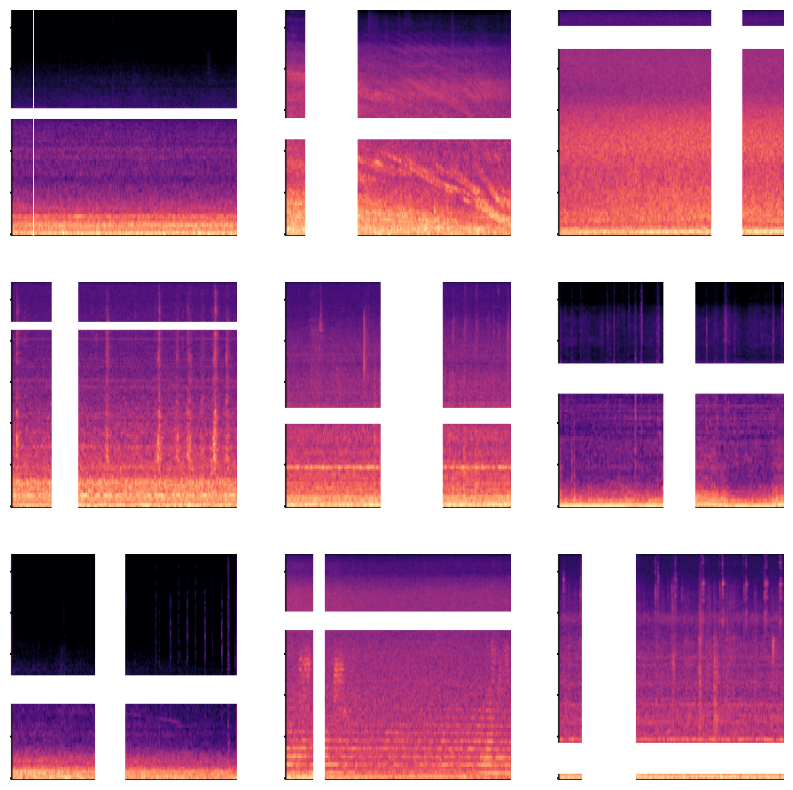

In [ ]:
import matplotlib.pyplot as plt

sample_images, sample_labels = next(iter(ds_spec_aug.take(10)))

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):

    #image = image / 255.0
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [ ]:
ds_spec_aug

<_LoadDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 15), dtype=tf.float32, name=None))>

In [ ]:
concatenated_dataset = train_ds_one.concatenate(ds_spec_aug.take(ds_spec_aug.cardinality()//2)) #modify according to batch size
concatenated_dataset = concatenated_dataset.shuffle(BATCH_SIZE*concatenated_dataset.cardinality())

#Step 5: Perform Spec Augment on Mix Up images

In [ ]:
import numpy as np

#extract all the images and labels in order to perform spec augment on each mixup image
all_images, all_labels = get_images_labels(train_ds_mu)

#apply the function to all the images
augmented_images = tf.map_fn(spec_augment, all_images)

ds_spec_aug_mix_up = (
    tf.data.Dataset.from_tensor_slices((augmented_images, all_labels))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

#Save the augmented ds
import tensorflow as tf

save_path = '/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_spec_aug_mixup_crop_16_mel.tfrecord'
tf.data.Dataset.save(ds_spec_aug_mix_up, save_path)


#Step 6: read the augmented saved files and prepare augmented datasets

In [ ]:
#Load the augmented spec_aug ds
import tensorflow as tf

saved_path = '/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_spec_aug_crop_16_mel.tfrecord'
ds_spec_aug = tf.data.Dataset.load(saved_path)

In [ ]:
#Load the augmented mix_up ds
import tensorflow as tf

saved_path = '/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_mixup_crop_mel_16.tfrecord'
ds_mix_up = tf.data.Dataset.load(saved_path)

In [ ]:
#Load the augmented spec_aug mix_up ds
import tensorflow as tf

saved_path = '/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_spec_aug_mixup_crop_16_mel.tfrecord'
ds_spec_aug_mix_up = tf.data.Dataset.load(saved_path)

We now choose to pick single images and labels for each dataset in order to shuffle them properly and not limit our selves in shuffling the batches

In [ ]:

all_images, all_labels = get_images_labels(train_dss)

all_images_spec_aug, all_labels_spec_aug = get_images_labels(ds_spec_aug)
all_images_mix_up, all_labels_mix_up = get_images_labels(ds_mix_up)
all_images_spec_aug_mix_up, all_labels_spec_aug_mix_up = get_images_labels(ds_spec_aug_mix_up)


In [ ]:
print(all_images.shape)
print(all_images_spec_aug.shape)
print(all_images_mix_up.shape)
print(all_images_spec_aug_mix_up.shape)

(3194, 256, 256, 3)
(3194, 256, 256, 3)
(1600, 256, 256, 3)


In [ ]:
#Now we concatenate and shuffle original ds plus around 30% for mixup, specaug and mixup+specaug
augmented_images = np.concatenate((all_images, all_images_spec_aug_mix_up[:700]), axis=0)
augmented_labels = np.concatenate((all_labels, all_labels_spec_aug_mix_up[:700]), axis=0)

augmented_images = np.concatenate((augmented_images, all_images_spec_aug[:700]), axis=0)
augmented_labels = np.concatenate((augmented_labels, all_labels_spec_aug[:700]), axis=0)

augmented_images_t = np.concatenate((augmented_images, all_images_mix_up[:700]), axis=0)
augmented_labels_t = np.concatenate((augmented_labels, all_labels_mix_up[:700]), axis=0)

augmented_train_mix = (
    tf.data.Dataset.from_tensor_slices((augmented_images_t, augmented_labels_t))
    .shuffle(6000)
    .batch(BATCH_SIZE)
)

In [ ]:
augmented_train_mix.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=331>

In [ ]:
#Save the augmented ds
import tensorflow as tf

save_path = '/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_mel_augmented_definitive_2.tfrecord'
tf.data.Dataset.save(augmented_train_mix, save_path)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999998807907104, 0.0, 9.822683466609305e-08, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.8964688777923584, 0.10353109985589981, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.04235987737774849, 0.0, 0.0, 0.0, 0.9576401114463806, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


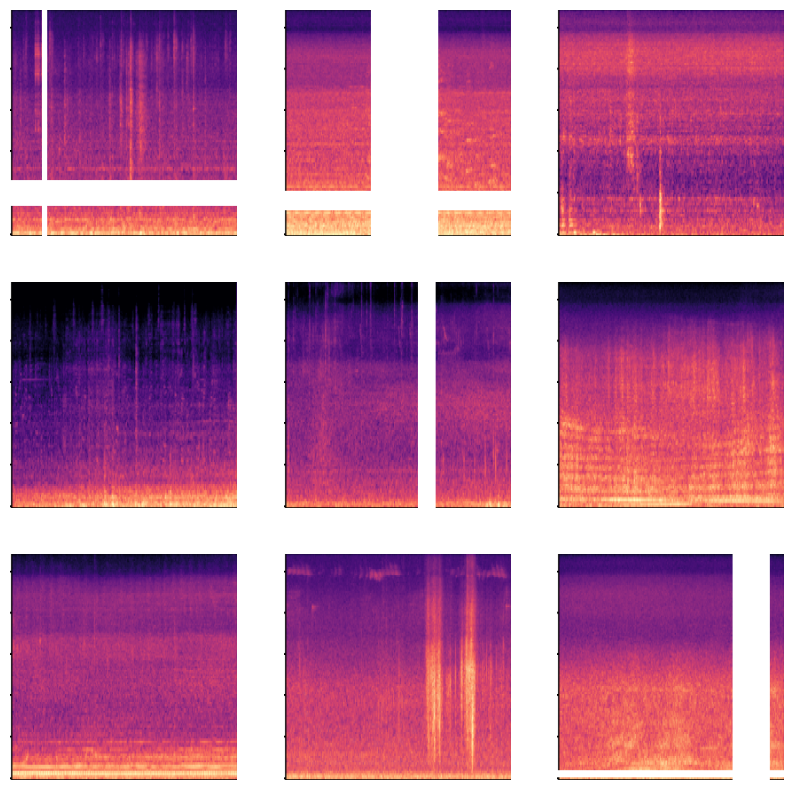

In [ ]:
import matplotlib.pyplot as plt

sample_images, sample_labels = next(iter(augmented_train_mix.take(10)))

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

